# World Wide Products Inc.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import datetime

## Exploratory Data Analysis and Preprocessing

In [2]:
products_df = pd.read_csv('../data/Historical Product Demand.csv')
products_df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


Let's narrow this dataset down to the particular product we will investigate. The products are uniquely identified, but not labeled. I will simply choose the one which we have the most data for.

In [3]:
products_df['Product_Code'].describe()

count          1048575
unique            2160
top       Product_1359
freq             16936
Name: Product_Code, dtype: object

In [4]:
products_df = products_df[products_df['Product_Code'] == 'Product_1359']
del products_df['Product_Code']
products_df

,Warehouse,Product_Category,Date,Order_Demand
276,Whse_J,Category_019,2012/4/18,80000
282,Whse_J,Category_019,2012/5/21,70000
289,Whse_J,Category_019,2012/6/26,80000
292,Whse_J,Category_019,2012/7/17,100000
296,Whse_J,Category_019,2012/8/24,100000
...,...,...,...,...
1046514,Whse_J,Category_019,2016/10/3,20000
1046515,Whse_J,Category_019,2016/9/16,10000
1046516,Whse_J,Category_019,2016/11/1,30000
1046517,Whse_J,Category_019,2016/12/1,20000


In [5]:
products_df.describe()

,Warehouse,Product_Category,Date,Order_Demand
count,16936,16936,16936,16936
unique,1,1,1232,161
top,Whse_J,Category_019,2013/1/7,1000
freq,16936,16936,35,2578


It appears that the warehouse and category associated with this product is constant. Therefore, we can elimintate these columns. This leaves the date as the single predictor of demand.

In [6]:
del products_df['Warehouse']
del products_df['Product_Category']
products_df

,Date,Order_Demand
276,2012/4/18,80000
282,2012/5/21,70000
289,2012/6/26,80000
292,2012/7/17,100000
296,2012/8/24,100000
...,...,...
1046514,2016/10/3,20000
1046515,2016/9/16,10000
1046516,2016/11/1,30000
1046517,2016/12/1,20000


As always, we will need to parse the date from a string into a more manageable format. While we are at it, let's ensure the data is chronological.

In [7]:
def parse_date(s: str):
    ymd = s.strip().split(sep='/')
    if len(ymd) != 3:
        return None
    else:
        [y, m, d] = ymd
        return datetime.date(int(y), int(m), int(d))
        

products_df = products_df.copy()
products_df['Date'] = products_df['Date'].apply(parse_date)
products_df = products_df.sort_values(by='Date')
products_df

,Date,Order_Demand
59646,2012-01-05,1000
63099,2012-01-05,5000
2577,2012-01-05,2000
32610,2012-01-05,10000
46739,2012-01-05,5000
...,...,...
870423,2016-12-28,3000
863720,2016-12-28,13000
864053,2016-12-28,50000
877287,2016-12-28,3000


In [8]:
products_df.dtypes

Date            object
Order_Demand    object
dtype: object

It appears that the demand is also an object, as opposed to a numerical type.

In [9]:
for d in products_df['Order_Demand']:
    d = d.strip()
    if not d.isnumeric():
        print(d)
        break

(1000)


It seems some of the demand entries are surrounded by parentheses, and that is why the column was parsed into a string.

In [10]:
def parse_demand(s : str):
    s = s.strip().strip('()')
    return int(s)

products_df['Order_Demand'] = products_df['Order_Demand'].apply(parse_demand)
products_df

,Date,Order_Demand
59646,2012-01-05,1000
63099,2012-01-05,5000
2577,2012-01-05,2000
32610,2012-01-05,10000
46739,2012-01-05,5000
...,...,...
870423,2016-12-28,3000
863720,2016-12-28,13000
864053,2016-12-28,50000
877287,2016-12-28,3000


Now that the date and demand are formatted to satisfaction, we can easily visualize our data.

In [11]:
products_df.plot(x='Date')

Periodic spikes are clearly observable, but no pattern is discernible beyond that. Let's zoom in closer to see if we can learn more.

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


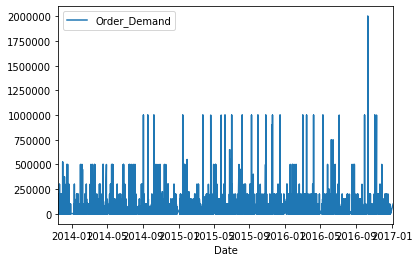

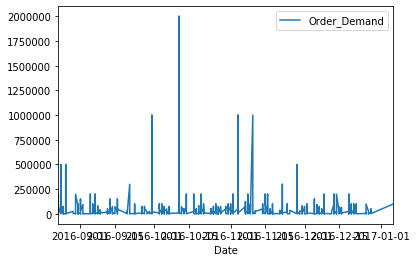

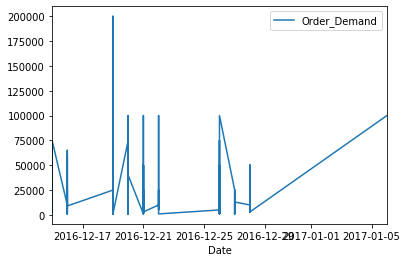

In [12]:
print(products_df.tail(10000).plot(x='Date'))
print(products_df.tail(1000).plot(x='Date'))
print(products_df.tail(100).plot(x='Date'))

Even as we zoom in, the demand appears to be quite erratic, with drastic spikes up and down. This seems to indicate that the demand does not vary in a clear pattern over time, but rather according to some unforseen period - perhaps relating to the season, the day of the week, or upcoming holidays. The primary goal of our feature engineering will be to extract periodic features that may have a more clear impact on the demand.

## Feature Engineering

Since the date is the only feature we have to aid our predictions, I will try to extract as many features as I can from it.

First, let's add the obvious features: year, month, and day. At the same time, we'll normalize the values such that 0 is the minimum value.

In [13]:
products_df['Year']  = products_df['Date'].apply(lambda d: d.year -2012)
products_df['Month'] = products_df['Date'].apply(lambda d: d.month -1)
products_df['Day']   = products_df['Date'].apply(lambda d: d.day -1)

products_df

,Date,Order_Demand,Year,Month,Day
59646,2012-01-05,1000,0,0,4
63099,2012-01-05,5000,0,0,4
2577,2012-01-05,2000,0,0,4
32610,2012-01-05,10000,0,0,4
46739,2012-01-05,5000,0,0,4
...,...,...,...,...,...
870423,2016-12-28,3000,4,11,27
863720,2016-12-28,13000,4,11,27
864053,2016-12-28,50000,4,11,27
877287,2016-12-28,3000,4,11,27


Let's also add a one-hot encoded features denoting the fiscal quarter, as well as the weekday.

In [14]:
products_df['Q1'] = products_df['Month'].apply(lambda m: 1 if 0 <= m <= 2  else 0)
products_df['Q2'] = products_df['Month'].apply(lambda m: 1 if 3 <= m <= 5  else 0)
products_df['Q3'] = products_df['Month'].apply(lambda m: 1 if 6 <= m <= 8  else 0)
products_df['Q4'] = products_df['Month'].apply(lambda m: 1 if 9 <= m <= 11 else 0)
products_df

,Date,Order_Demand,Year,Month,Day,Q1,Q2,Q3,Q4
59646,2012-01-05,1000,0,0,4,1,0,0,0
63099,2012-01-05,5000,0,0,4,1,0,0,0
2577,2012-01-05,2000,0,0,4,1,0,0,0
32610,2012-01-05,10000,0,0,4,1,0,0,0
46739,2012-01-05,5000,0,0,4,1,0,0,0
...,...,...,...,...,...,...,...,...,...
870423,2016-12-28,3000,4,11,27,0,0,0,1
863720,2016-12-28,13000,4,11,27,0,0,0,1
864053,2016-12-28,50000,4,11,27,0,0,0,1
877287,2016-12-28,3000,4,11,27,0,0,0,1


In [15]:
listmap = lambda f, l: list(map(f, l))

weekdays = pd.get_dummies(products_df['Date'].apply(lambda d: d.weekday()))
weekday_columns = listmap(lambda w: "W_"+str(w), weekdays.columns)

products_df[weekday_columns] = weekdays
products_df

,Date,Order_Demand,Year,Month,Day,Q1,Q2,Q3,Q4,W_0,W_1,W_2,W_3,W_4,W_5,W_6
59646,2012-01-05,1000,0,0,4,1,0,0,0,0,0,0,1,0,0,0
63099,2012-01-05,5000,0,0,4,1,0,0,0,0,0,0,1,0,0,0
2577,2012-01-05,2000,0,0,4,1,0,0,0,0,0,0,1,0,0,0
32610,2012-01-05,10000,0,0,4,1,0,0,0,0,0,0,1,0,0,0
46739,2012-01-05,5000,0,0,4,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870423,2016-12-28,3000,4,11,27,0,0,0,1,0,0,1,0,0,0,0
863720,2016-12-28,13000,4,11,27,0,0,0,1,0,0,1,0,0,0,0
864053,2016-12-28,50000,4,11,27,0,0,0,1,0,0,1,0,0,0,0
877287,2016-12-28,3000,4,11,27,0,0,0,1,0,0,1,0,0,0,0


Finally, even though the data appeared largely cyclical as opposed to displaying a general trend, I will add a "seconds" column, indicating how much time has elapsed since the earliest recorded datapoint.

In [16]:
earliest = min(products_df['Date'])

products_df['Seconds'] = products_df['Date'].apply(lambda d: int((d - earliest).total_seconds()))
products_df

,Date,Order_Demand,Year,Month,Day,Q1,Q2,Q3,Q4,W_0,W_1,W_2,W_3,W_4,W_5,W_6,Seconds
59646,2012-01-05,1000,0,0,4,1,0,0,0,0,0,0,1,0,0,0,0
63099,2012-01-05,5000,0,0,4,1,0,0,0,0,0,0,1,0,0,0,0
2577,2012-01-05,2000,0,0,4,1,0,0,0,0,0,0,1,0,0,0,0
32610,2012-01-05,10000,0,0,4,1,0,0,0,0,0,0,1,0,0,0,0
46739,2012-01-05,5000,0,0,4,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870423,2016-12-28,3000,4,11,27,0,0,0,1,0,0,1,0,0,0,0,157161600
863720,2016-12-28,13000,4,11,27,0,0,0,1,0,0,1,0,0,0,0,157161600
864053,2016-12-28,50000,4,11,27,0,0,0,1,0,0,1,0,0,0,0,157161600
877287,2016-12-28,3000,4,11,27,0,0,0,1,0,0,1,0,0,0,0,157161600


## Modeling

Now we have plenty of features to attempt a time series forcast. 

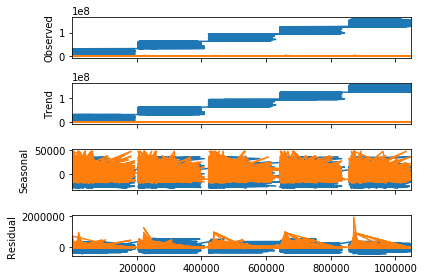

In [17]:
dec = sm.tsa.seasonal_decompose(products_df[['Seconds', 'Order_Demand']], freq=360)
_ = dec.plot()

This naive decomposition does not appear very convinving. Let's bring out the big guns and throw a neural network at the problem. This will also be able to utilize the full range of features we extracted earlier.

In [18]:
import tensorflow as tf
from tensorflow import keras

In [19]:
len_total = len(products_df)
len_train = int(.9 * len_total)
len_test  = len_total - len_train

labels    = products_df['Order_Demand']
nonlabels = products_df.copy()
del nonlabels['Date']
del nonlabels['Order_Demand']

train_input  = nonlabels.head(len_train).to_numpy()
train_labels = labels.head(len_train).to_numpy()

test_input  = nonlabels.tail(len_test).to_numpy()
test_labels = labels.tail(len_test).to_numpy()

In [33]:
len_hidden = len(nonlabels.columns)

model = tf.keras.Sequential([
    keras.layers.Dense(len_hidden, activation='relu'),
    keras.layers.Dense(len_hidden*4, activation='relu'),
    keras.layers.Dense(len_hidden*4, activation='relu'),
    keras.layers.Dense(len_hidden*4, activation='relu'),
    keras.layers.Dense(len_hidden*4, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.RMSprop(0.01),
              metrics=['mae','mse']
             )

In [34]:
model.fit(train_input, train_labels, epochs=100, verbose=0)

In [35]:
print(model.evaluate(test_input, test_labels, verbose=0))

[7359226535.291617, 31693.334, 7359226400.0]


## Conclusion

The results of both the decomposition and the neural network are dissapointing. It is difficult to say whether the models were lacking, or if the product I chose is inherently volatile and hard to predict.